 ### Import necessary packages

In [2]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

### Read in csv file

In [3]:
df1 = pd.read_csv(r"/Users/seantan88/Documents/GitHub/ElectricityCluster/CSV data/Combined Data/CSD_Merit_2023.csv")

### Run elbow method to determine optimal number of clusters

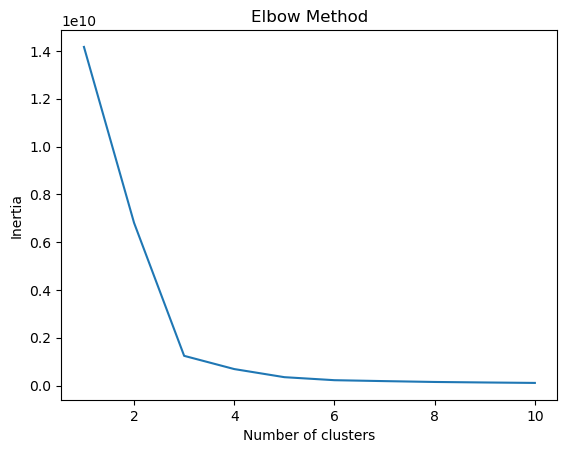

In [5]:

# perform the elbow method to determine the optimal number of clusters
# create a list of inertia values for each number of clusters
inertia = []
# loop through the number of clusters from 1 to 10
for i in range(1, 11):
    # create a kmeans model
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    # fit the model to the features
    kmeans.fit(df1[['block_price', 'System Capability']])
    # append the inertia value to the list
    inertia.append(kmeans.inertia_)


# plot the inertia values
plt.plot(range(1, 11), inertia)
# add labels
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
# show the plot
plt.show()

### Run a K-Means clustering algorithm

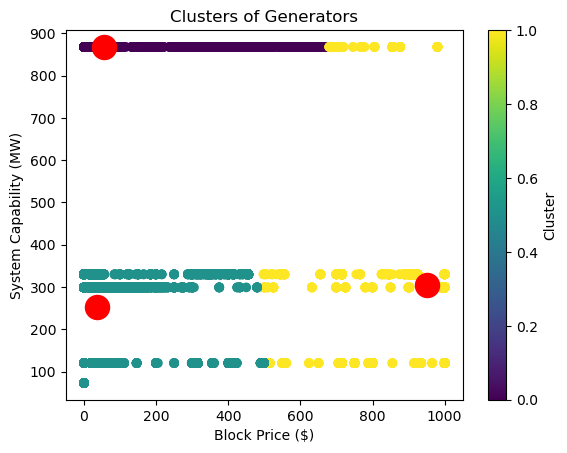

In [7]:
# fit the kmeans model to the features, using 3 clusters
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
# fit the model to the features
kmeans.fit(df1[['block_price', 'System Capability']])
# add a new column to df3 that contains the cluster labels
df1['cluster'] = kmeans.labels_
# create new figure
plt.figure()

# plot the clusters
plt.scatter(df1['block_price'], df1['System Capability'], c = kmeans.labels_, cmap = 'viridis')
# plot the centroids
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'red')
# add the generator ids to the plot so we can see which generators are in each cluster
#for i in range(len(df3['asset_ID'])):
    #plt.text(df3['block_price'][i], df3['System Capability'][i], df3['asset_ID'][i])
# add labels
plt.title('Clusters of Generators')
plt.colorbar(label= 'Cluster')
plt.xlabel('Block Price ($)')
plt.ylabel('System Capability (MW)')
# show the plot
plt.show()


### Overview of monthly block price average for combined-cycle generators

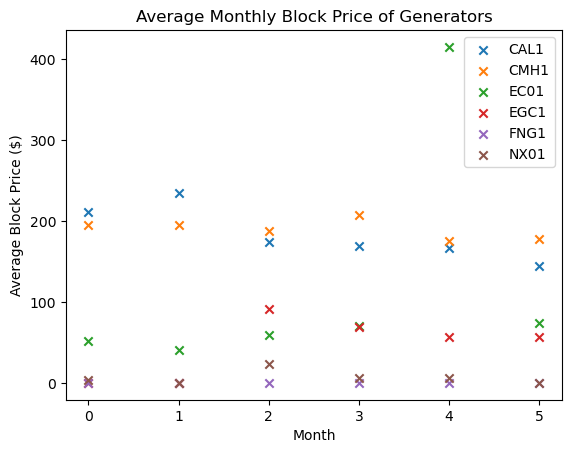

In [23]:
# load the data in
df2 = pd.read_csv(r"/Users/seantan88/Documents/GitHub/ElectricityCluster/CSV data/Generator Specific Data/asset_monthly_average.csv")
# create a scatterplot of the average monthly block price of each generator

# drop the first column of df2, which contains the months
df2 = df2.drop(columns = 'begin_dateTime_mpt')

# create new figure
plt.figure()
# plot the average monthly block price of each generator
for column in df2.columns:
    plt.scatter(df2.index, df2[column], label = column, marker = 'x')
# add labels
plt.title('Average Monthly Block Price of Generators')
plt.xlabel('Month')
plt.ylabel('Average Block Price ($)')
# show the legend
plt.legend()
# show the plot
plt.show()







 ### ADD DESCRIPTION AND EXPLANATION ** ASK GILBERT ** 

### Plot average block price and standard deviation of block price at 7am (beginning of peak hours)

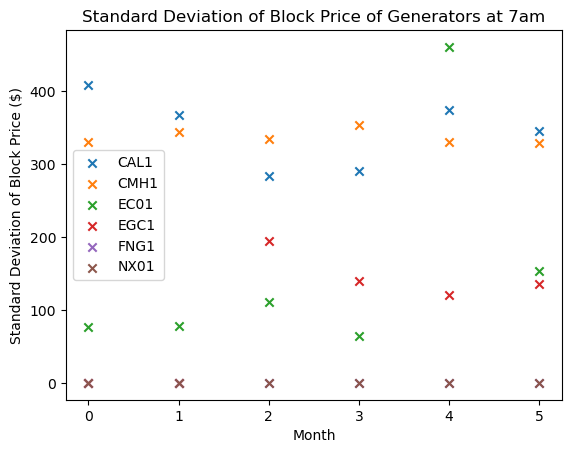

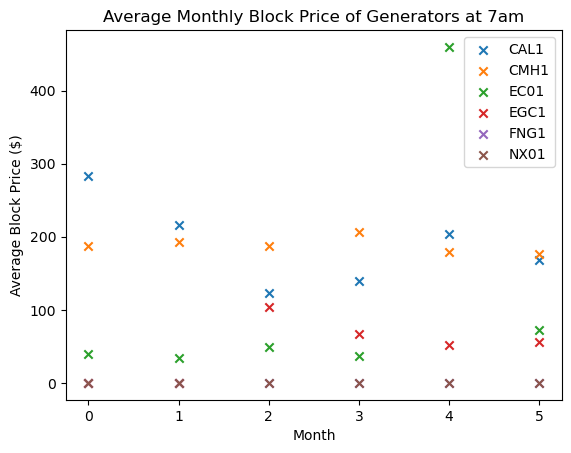

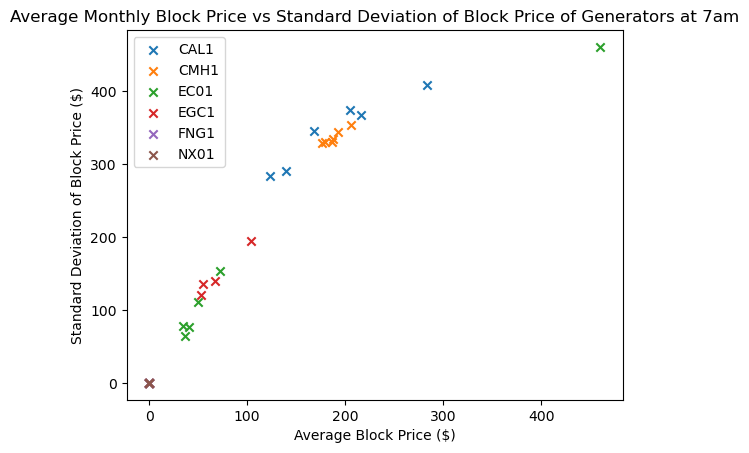

In [30]:
std_dev_df = pd.read_csv(r"/Users/seantan88/Documents/GitHub/ElectricityCluster/CSV data/Standard Deviation/7am/asset_monthly_std_dev.csv")
average_df = pd.read_csv(r"/Users/seantan88/Documents/GitHub/ElectricityCluster/CSV data/Standard Deviation/7am/asset_monthly_average.csv")

# drop the first column of each df, which contains the months
std_dev_df = std_dev_df.drop(columns = 'Unnamed: 0')
average_df = average_df.drop(columns = 'Unnamed: 0')
# scatterplot the standard deviation of the block price of each generator each month and the average monthly block price each month
# create new figure
plt.figure()
# plot the standard deviation of the block price of each generator each month
for column in std_dev_df.columns:
    plt.scatter(std_dev_df.index, std_dev_df[column], label = column, marker = 'x')
# add labels
plt.title('Standard Deviation of Block Price of Generators at 7am')
plt.xlabel('Month')
plt.ylabel('Standard Deviation of Block Price ($)')
# show the legend
plt.legend()
# show the plot
plt.show()

# create new figure
plt.figure()
# plot the average monthly block price of each generator
for column in average_df.columns:
    plt.scatter(average_df.index, average_df[column], label = column, marker = 'x')
# add labels
plt.title('Average Monthly Block Price of Generators at 7am')
plt.xlabel('Month')
plt.ylabel('Average Block Price ($)')
# show the legend
plt.legend()
# show the plot
plt.show()


# plot them against each other
plt.figure()
for column in average_df.columns:
    plt.scatter(average_df[column], std_dev_df[column], label = column, marker = 'x')
plt.title('Average Monthly Block Price vs Standard Deviation of Block Price of Generators at 7am')
plt.xlabel('Average Block Price ($)')
plt.ylabel('Standard Deviation of Block Price ($)')
plt.legend()
plt.show()